# Lane Finding

In this notebook we explore techniques from classical computer vision (CV) to perform the task of *lane finding*, i.e. our goal is to detect lanes on a road. This information is essential in the context of self-driving cars.

The rough overview of the lane detection pipeline in a single image is as follows:

1. Calibrate the camera in order to be able to correct for distortion
2. Use thresholding/area selection/color selection/... to transform the image into a binary image containing (in the ideal case) only the lane lines.
3. Make a perspective transformation to have a top-down view on the lanes
4. Do the actual lane detection
5. Fit a quadratic polynomial to the detected pixels
6. Determine the lane curvature
7. Use the inverse transformation of the above perspective transformation to mark the lanes in the original image

This is the pipeline for a **single image**. Ultimately, we are interested in applying lane detection on a sequence of images (i.e. a video). This allows us to leverage information of the additional temporal information: it is very reasonable to assume that the lane lines do not jump too much from one frame to the next. So, if we are confident that we found the correct lane lines, it suffices to search in a relatively small area around these lane lines in the next frame. 
Furthrmore, it is possible that the detected lane lines jump quite a lot from one frame to the next. In order to reduce this effect, we average the lane line parameters over the sequence of a few images.

Next, we give a step-by-step description of this pipeline, in the course of which we define the helper functions to be used in the final pipeline.

# Camera calibration

We start with the process of camera calibration. In the folder './camera_cal', there are 20 images of chessboards of type (9,6) to be used for calibration. We show two of them below:

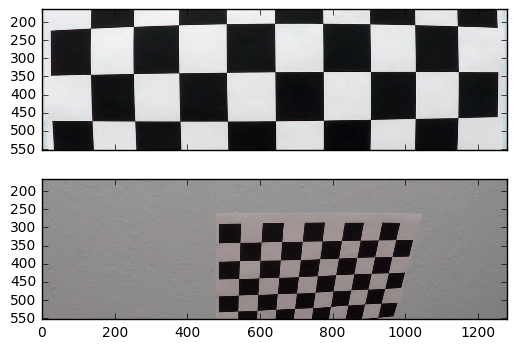

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)

axarr[0].imshow(cv2.imread('./camera_cal/calibration1.jpg'))
axarr[1].imshow(cv2.imread('./camera_cal/calibration10.jpg'))

The process of camera calibration consists of identifying the chessboard edges in the calibration images. We know that they should be in a plane and we can define the points where they should be warped (`objpoints` below). Once the edges have been detected, this allows us to extract the affine transformation mapping the image points to the object points (and its inverse).

In our situation, the chessboard consists of 9 interior corners in the x direction and 6 interior corners in the y direction. Thus, the object points `objpoints` are (0, 0, 0), (1, 0, 0), ..., (0, 1, 0), (1, 1, 0), ..., (9, 6, 0). The code cell below finds the chessboard corners for the 20 images. Whenever it finds the object, it appends the object points to a list and saves the pixel coordinates (image points) as well.

In [2]:
import numpy as np
import glob

def get_objpoints_imgpoints():
    # Define object points
    objp = np.zeros((9 * 6, 3))
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    imgpoints = []
    objpoints = []

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')
    

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp.astype('float32'))
            imgpoints.append(corners.astype('float32'))
        
    return objpoints, imgpoints

objpoints, imgpoints = get_objpoints_imgpoints()

**Here it is shown how the camera matrix and distortion coefficients have been computed and examples of distorted and undistorted images are provided**.

Now, that the image points of the chessboard corners have been detected, we can apply the OpenCV function, `cv2.calibrateCamera` that is able to combine multiple images (to reduce noise) to compute the calibration coefficients. We save everything we need in the variable `CALIBRATION_DICT`.

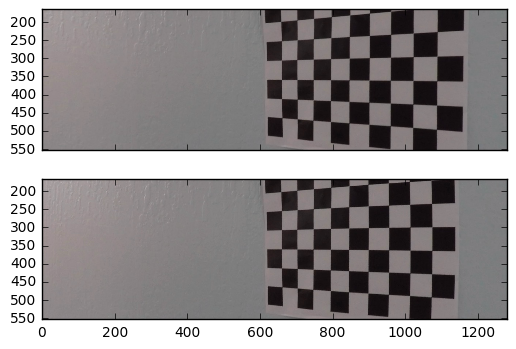

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration12.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

f, axarr = plt.subplots(2, sharex=True)
axarr[1].imshow(img)
axarr[0].imshow(dst)

CALIBRATION_DICT = {'ret': ret, 'mtx': mtx, 'dist': dist, 'rvecs': rvecs, 'tvecs': tvecs}

## Test

This is meant to be a short test to show that the camera calibration worked. A transformation was added to warp the chessboard in a plane.

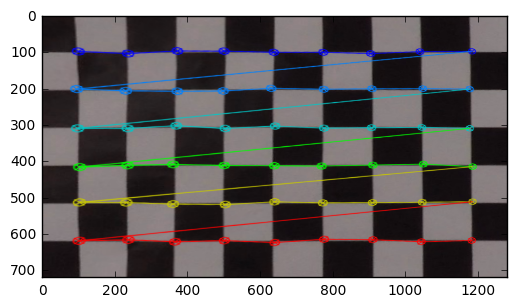

In [4]:
nx = 9
ny = 6

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

foo, M = corners_unwarp(img, nx, ny, CALIBRATION_DICT['mtx'], CALIBRATION_DICT['dist'])
plt.imshow(foo)

At this point, we have the matrix necessary to perform the undistortion transformation.

## Distortion corrected road image

We provide another example, this time with a picture from the road:



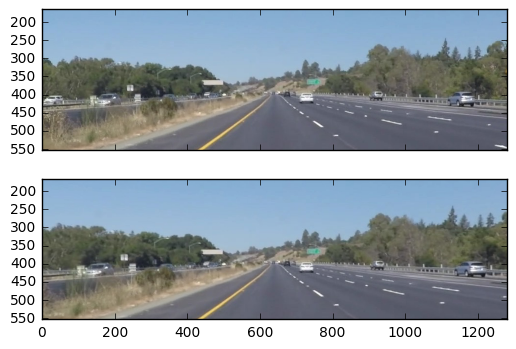

In [26]:
test_img = cv2.imread('./test_images/solidYellowLeft.jpg')
test_img = cv2.resize(test_img, (1280, 720)) 
test_img_undist = cv2.undistort(test_img, CALIBRATION_DICT['mtx'], CALIBRATION_DICT['dist'], None, CALIBRATION_DICT['mtx'])

f, axarr = plt.subplots(2, sharex=True)
axarr[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(test_img_undist, cv2.COLOR_BGR2RGB))

# Perspective transform

Here, we extract the objects necessary to perform the perspective transform. The goal of the perspective transform in our case is to obtain a top-down view on the street. This allows us much easier to identify the curvature of the lane lines and thus of the road.

So with this in mind, we have to select an image where the road is straight. This allows us to draw a trapezoid around portions of the left and right lane (as parallel to the lane lines as possible). We know that viewed from top-down this looks like a rectangle. So then we just have to define the desired image points of the corners of the trapezoid to be a rectangle.

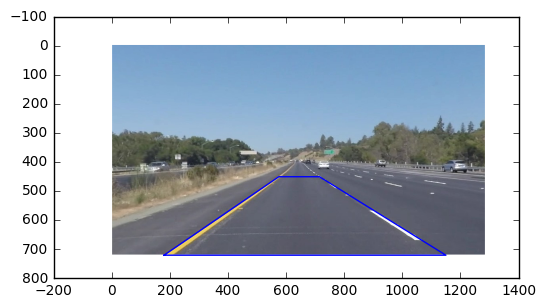

In [27]:
plt.imshow(cv2.cvtColor(test_img_undist, cv2.COLOR_BGR2RGB))
plt.plot([180, 1150, 715, 575, 180], [720, 720, 450, 450, 720])

As mentioned above, in the transformed image, we want the corners of the blue lines to be the edges of a rectangle. These four points (together with their desired image points) uniquely define the warp transformation. This transformation, in turn, can be computed using the OpenCV function `cv2.getPerspectiveTransform`. In the code cell below, we also compute the inverse of the transform and save the result in the dictionary `WARP_MATRICES`.

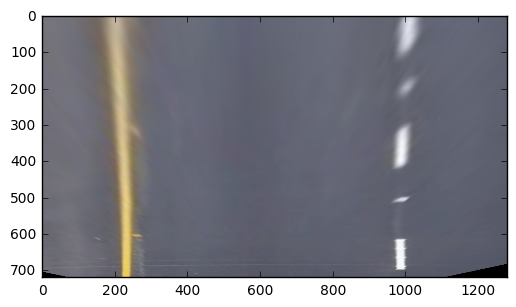

In [28]:
def corners_unwarp(img):
    # Copy input image and determine its size
    warped = np.copy(img) 
    img_size = img.shape[0:2]
    img_size = (img_size[1], img_size[0])
    
    # Define the four corners in the original image
    src = np.float32([[220, 720], [1150, 720], [708, 450], [585, 450]])
    
    # Define the four corners in the wapred image
    dest = np.float32([[250, 720], [1000, 720], [1000, 0], [250, 0]])
    
    # Compute the transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dest)
    M_inv = cv2.getPerspectiveTransform(dest, src)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    warp_matrices = {'M': M, 'M_inv': M_inv}
    
    return warped, warp_matrices

test_img_warped, WARP_MATRICES = corners_unwarp(test_img_undist)
plt.imshow(cv2.cvtColor(test_img_warped, cv2.COLOR_BGR2RGB))

The result looks quite good.

# Selecting Lane pixels

The next step consists in filtering the image pixels such that we are left with only lane line pixels as well as possible. Note that the perspective transform from above performs the region selection for us quite well. We start by selecting pixels based on **gradients**:

## Gradient threshold

Below, three functions for threshold selection were implemented:

1. `abs_sobel_threshold`: it takes all pixels in a gray version of the image where the gradient (Sobel operator) is between the bounds defined by the argument `thresh`.
2. `mag_threshold`: the second thresholding function is based on the absolute value of the derivative.
3. `dir_treshold`: finally, the third function is based on the direction of the gradient.

These functions can then be combined via the `combine_thresholds` function. A pixel is kept after the `combine_thresholds` function has been applied if and only if:

+ It satisfies the x derivative **and** y derivative constraint defined by `abs_sobel_threshold` **or**
+ it satisfies the magnitude threshold constraint **and** the direction threshold constraint.

In [29]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    derivative_absolute = np.absolute(derivative)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * derivative_absolute / np.max(derivative_absolute))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image) # Remove this line
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobel_abs = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * sobel_abs / np.max(sobel_abs))
    # 6) Create a binary mask where mag thresholds are met
    binary_mask = np.zeros(scaled_sobel.shape)
    binary_mask[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 7) Return this mask as your binary_output image
    binary_output = np.copy(img) # Remove this line
    return binary_mask

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combine_thresholds(img, ksize=3, x_thresh=(0, 255), y_thresh=(0, 255), abs_thresh=(0, 255), dir_thresh=(0, np.pi/2)):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=x_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=y_thresh)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=abs_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return(combined)

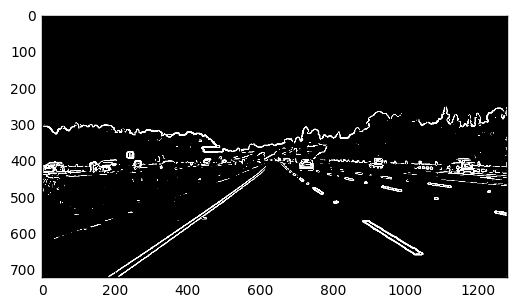

In [30]:
combined = combine_thresholds(test_img, ksize=9, x_thresh=(20, 120), y_thresh=(40, 40), abs_thresh=(50, 250), dir_thresh=(0.7, 1.3))
plt.imshow(combined, cmap='gray')

Even, at this stage, the results look quite promising.

## HSV thresholding

Next, we do thresholding based on pixel values only. In following codeblock, the function `hsv_select` is defined. This function transforms the image to HSV color space, and selects pixels based on their their pixel values. Two threshold arrays are defined, one for white lane lines and one for yellow lane lines. If a pixel lies between the boundary values, it is retained.

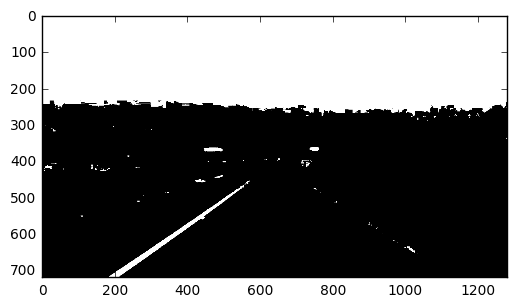

In [31]:
def hsv_select(img, white_thresh, yellow_thresh):
    # 1) Convert to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply white threshold
    binary_img = np.zeros_like(img[:, :, 0])
    binary_img[(hsv_img[:, :, 0] >= white_thresh[0, 0]) & 
               (hsv_img[:, :, 1] >= white_thresh[0, 1]) & 
               (hsv_img[:, :, 2] >= white_thresh[0, 2]) & 
               (hsv_img[:, :, 0] <= white_thresh[1, 0]) & 
               (hsv_img[:, :, 1] <= white_thresh[1, 1]) & 
               (hsv_img[:, :, 2] <= white_thresh[1, 2])] = 1
    
    # Apply yellow threshold
    binary_img[(hsv_img[:, :, 0] >= yellow_thresh[0, 0]) & 
               (hsv_img[:, :, 1] >= yellow_thresh[0, 1]) & 
               (hsv_img[:, :, 2] >= yellow_thresh[0, 2]) & 
               (hsv_img[:, :, 0] <= yellow_thresh[1, 0]) & 
               (hsv_img[:, :, 1] <= yellow_thresh[1, 1]) & 
               (hsv_img[:, :, 2] <= yellow_thresh[1, 2])] = 1
    
    
    
    # 3) Return a binary image of threshold result
    binary_output = np.copy(img) # placeholder line
    return binary_img

yellow_thresh = np.array([[0, 80, 150],
                          [120, 255, 255]])

white_thresh = np.array([[20, 0, 200],
                         [255, 80, 255]])

plt.imshow(hsv_select(test_img, yellow_thresh=yellow_thresh, white_thresh=white_thresh), cmap='gray')

We, indeed, see that the lane lines are selected very well.

## Combination

In [32]:
THRESH_DICT = {'ksize':9, 'x_thresh':(20, 110), 'y_thresh':(40, 40), 'abs_thresh':(50, 255), 'dir_thresh':(0.85, 1.1),
              's_thresh': (90, 90), 'h_thresh': (15, 15), 'yellow_thresh': np.array([[0, 80, 150], [120, 255, 255]]),
               'white_thresh': np.array([[20, 0, 200], [255, 80, 255]])}

def pipeline(img, CALIBRATION_DICT, THRESH_DICT, WARP_MATRICES):
    # Undistort image
    img_undistorted = cv2.undistort(img, CALIBRATION_DICT['mtx'], CALIBRATION_DICT['dist'], None, 
                                    CALIBRATION_DICT['mtx'])
    
    # Calculating gradient threshold
    gradients_threshs = combine_thresholds(img_undistorted, ksize=THRESH_DICT['ksize'], 
                                           x_thresh=THRESH_DICT['x_thresh'], y_thresh=THRESH_DICT['y_thresh'],
                                           abs_thresh=THRESH_DICT['abs_thresh'], dir_thresh=THRESH_DICT['dir_thresh'])
    
    # HSV thresholds
    hsv_threshs = hsv_select(img_undistorted, white_thresh=THRESH_DICT['white_thresh'],
                            yellow_thresh = THRESH_DICT['yellow_thresh'])
    
    binary_img = np.zeros_like(img)[:, :, 0]
    binary_img[(gradients_threshs == 1) | (hsv_threshs == 1)] = 1
    color_binary = np.dstack(( np.zeros_like(img)[:, :, 0] , gradients_threshs, hsv_threshs))
    
    img_size = (binary_img.shape[1], binary_img.shape[0])
    warped = cv2.warpPerspective(binary_img, WARP_MATRICES['M'], img_size, flags=cv2.INTER_LINEAR)
    return warped
    

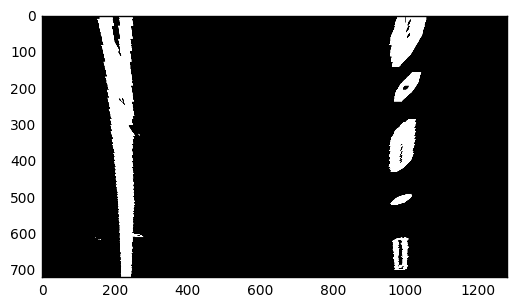

In [33]:
plt.imshow(pipeline(test_img, CALIBRATION_DICT, THRESH_DICT, WARP_MATRICES), cmap='gray')

# Detecting the lane lines

Now, the actual lane detection proceeds as follows: 

+ We first compute a histogram of the pixel intensity of the lower half of the thresholded, warped image. 
+ Then, we identify the peak in the left half and the peak in the right half. These correpond to the rough positions of the lane lines.
+ The next step is to use a sliding window around these peaks to detect the lane lines.

## Histograms

Let us start with the first step: here we show the histogram of pixel intensities of the lower half of the image above. We can clearly identify two peaks visually.

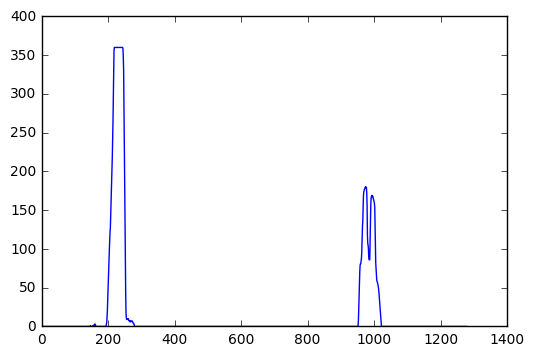

In [34]:
test_img_filtered = pipeline(test_img, CALIBRATION_DICT, THRESH_DICT, WARP_MATRICES)
def calculate_histogram(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    return(histogram)
histogram = calculate_histogram(test_img_filtered)
plt.plot(histogram)

The next step is to extract the peaks programatically:

+ First, we search for the peaks of the histogram in the left and right half, respectively. This gives us starting points for a sliding windows search.
+ The next step is to use sliding windows to search for more lane lines. What we do in this search, is to define a window and to look if inside of this windows there are enough detected pixels so that we can safely say that the window is part of the lane line.
+ The window is defined iteratively: the first step comes from the histogram search defined above. In the second step, we look one window margin higher in the image. The x-direction center of the window is defined as the mean x-position where lane pixels were detected one step before. This procedure continues.
+ Once all pixels are detected, we fit a quadratic polynomial, $f(y) = a y ^ 2 + b y + c$ to define the final lane lines.

In [35]:
binary_img = pipeline(test_img, CALIBRATION_DICT, THRESH_DICT, WARP_MATRICES)

def calculate_lane_poly(binary_img):
    histogram = calculate_histogram(binary_img)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_img.shape[0]/nwindows)

    #Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit)

def calculate_lane_pixel(left_fit, right_fit, y_vec = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])):
    fit_leftx = left_fit[0]*y_vec**2 + left_fit[1]*y_vec + left_fit[2]
    fit_rightx = right_fit[0]*y_vec**2 + right_fit[1]*y_vec + right_fit[2]
    
    return (fit_leftx, fit_rightx)

left_fit, right_fit = calculate_lane_poly(binary_img)
y_vec = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
fit_leftx, fit_rightx = calculate_lane_pixel(left_fit, right_fit)

Let us visualize the results below: looks quite good!

(720, 0)

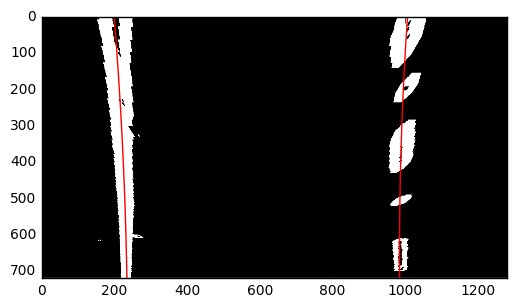

In [36]:
plt.imshow(binary_img, cmap='gray')
plt.plot(fit_leftx, y_vec, color='red')
plt.plot(fit_rightx, y_vec, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Radius of curvature calculation

Now, that we have fit a quadric polynomial $x = f(y)$, we can use this to calculate the radius of curvature: it is given by $R_{curve} = \frac{\left[1 + \left(\frac{dx}{dy}\right) ^ 2 \right] ^ {3 / 2}}{\left \vert \frac{d ^ 2 x}{dy^2}\right \vert}$. With a quadratic polynomial $f(y) = a y ^ 2 + b y + c$, this boils down to

$$R_{curve} = \frac{\left(1 + \left( 2 a y + b\right) ^ 2\right) ^ {3 / 2}}{\vert 2 a\vert}$$

This gives the radius curvature in units of the image, i.e. pixels. This is, of course, not a useful quantity. We are interested in computing the radius of curvature in physical units. One alternative would be to refit the polynomial again after converting everything to physical units. It is, however, also very easy to do the conversion: let $x' = \alpha x$ be the $x$ coordinate in meters, and similarly, let $y' = \beta y$ be the $y$-coordinate in meters. Furthermore, let the best quadratic fit in meter units be $f(y') = a' x' ^ 2 + b' y' + c'$. Then it is easy to show that we have the following relations:

$$a' = a \alpha / \beta  ^ 2$$
$$b' = b \alpha / \beta$$
$$c' = c / \beta'$$

The following code chunk implements this computation:

In [37]:
# Define conversions in x and y from pixels space to meters
def calculate_R_curve(left_fit, right_fit):
    pix_per_ym = 720 / 30
    pix_per_xm = 700 / 3.7

    left_fit_m = [left_fit[0] * pix_per_ym ** 2 / pix_per_xm, left_fit[1] * pix_per_ym / pix_per_xm, left_fit[2] / pix_per_xm]
    right_fit_m = [right_fit[0] * pix_per_ym ** 2 / pix_per_xm, right_fit[1] * pix_per_ym / pix_per_xm, right_fit[2] / pix_per_xm]


    y_eval = 120
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    
    return (left_curverad, right_curverad)
    
calculate_R_curve(left_fit, right_fit)

(3678.4570595599962, 3122.6810597103304)

## Calculate Lane offset

Next, we calculate the lane offset. For that we need the two lane lines at the lowest point in the image. We take the middle point between the two lanes and subtract the image center. This gives us the lane offset in pixel. Finally, we convert that number to meters.

In [38]:
def calculate_offset(left_fit, right_fit):
    # Horizontal distances
    fity = 720
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    lane_midpoint = (fit_leftx + fit_rightx) / 2
    offset = lane_midpoint - 1280 / 2
    offset_m = offset * 3.7 / 700
    return offset_m
    
calculate_offset(left_fit, right_fit)

-0.16248278339728647

## Warp lange lines back

The final step in detecting lane lines on a single image is to actually warp the lane back onto the original image.

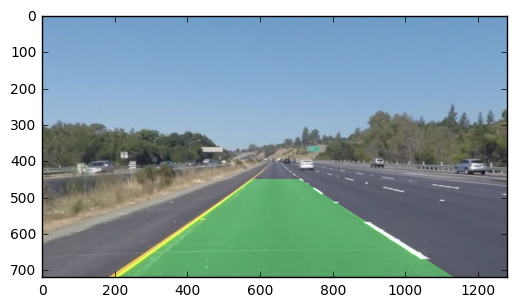

In [39]:
def warp_back(warped_img, original_img, fit_leftx, fit_rightx, y_vec, WARP_MATRICES):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = warp_zero

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, y_vec]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, y_vec])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, WARP_MATRICES['M_inv'], (original_img.shape[1], original_img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result

    
plt.imshow(cv2.cvtColor(warp_back(test_img_warped, test_img_undist, fit_leftx, fit_rightx, y_vec, WARP_MATRICES), cv2.COLOR_BGR2RGB))

# Full single image pipeline

Finally we put everything together into the single image pipeline:

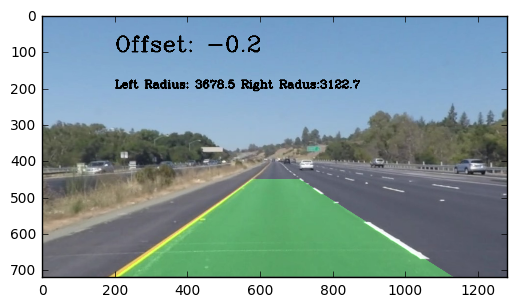

In [40]:
def process_image(img):
    # Undistort
    img_undistorted =  cv2.undistort(img, 
                                    CALIBRATION_DICT['mtx'],
                                    CALIBRATION_DICT['dist'], 
                                    None,
                                    CALIBRATION_DICT['mtx'])
    
    img_warped = corners_unwarp(img_undistorted)[0]
    
    # Select lane pixels and warp
    binary_img = pipeline(img, CALIBRATION_DICT, THRESH_DICT, WARP_MATRICES)
    plt.imshow(binary_img)
    
    # Fit poly and calculate fitted pixels
    left_fit, right_fit = calculate_lane_poly(binary_img)
    y_vec = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    fit_leftx, fit_rightx = calculate_lane_pixel(left_fit, right_fit)
    
    # Calculate radius of curvature and offset
    R_curv = calculate_R_curve(left_fit, right_fit)
    offset = calculate_offset(left_fit, right_fit)
    
    
    # Make sanity check
    #sanity_check(left_fit, right_fit) # TO BE DONE
    
    # Warp back
    warped_back = warp_back(img_warped, img_undistorted, fit_leftx, fit_rightx, y_vec, WARP_MATRICES)
    #print(R_curv[0])
    cv2.putText(warped_back, "Left Radius: {:.5} Right Radus:{:.5}".format(R_curv[0], R_curv[1]), (200, 200), cv2.FONT_HERSHEY_COMPLEX, 1, 0, 4)
    cv2.putText(warped_back, "Offset: {:.1}".format(offset), (200, 100), cv2.FONT_HERSHEY_COMPLEX, 2, 0, 4)
    
    
    return warped_back

plt.imshow(cv2.cvtColor(process_image(test_img), cv2.COLOR_BGR2RGB))

# Video pipeline

Now, we put the entire pipeline constructed until now to use in a video:

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [17:21<00:00,  1.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 10min 44s, sys: 2min 38s, total: 13min 23s
Wall time: 17min 25s


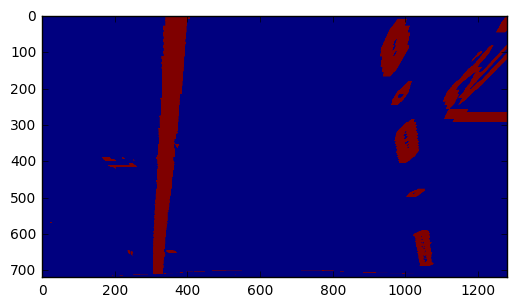

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'project_output.mp4'
clip2 = VideoFileClip('./project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(project_output, audio=False)

# Discussion

## Issues

The main issues faced in this project, was to find good thresholding parameters that cover all different situations. There are good parameter values for each individual image, but it a non-trivial task to find good parameters that run over the entire range of a video (evan a simple video like `project_video.mp4`)

## Improvements

There are many improvements that could be made, even using techniques from classical computer vision:

+ Take averages over the polynomial over several images: this would make the pipeline more robust
+ Calculate a "probability" that newly detecte lane lines are correct: for example, if there are pretty big jumps from one iamage to the next, and the images from the past second were consistent with each other, it is unlikely that the new lane lines are correct. In that situation, we might prefer to keep with the lane lines from the last second
+ Sanity checks: for example, the lane lines should be parallel, the radius of curvature should be within a certain range, etc. If these sanity checks fail, then we should warn the driver that there is probably a problem.

One of the best ways of improving the entire pipeline might be to switch to a deep learning approach. Of course, the question arises of how get training data. One way would be to select images from the classical computer vision approach, validated by a human.

## Probable failures

There are many situations in which the current approach might fail: 

+ different light conditions, e.g. evening
+ wet roads
+ if there is a large gradient at the boundary of the warped image: this could be, for example, due to road the street limit
+ if there is a car right in front of our car, it might be detected as lane line
+ During construction work (at least here in Europe), relevant lane lines change colors (from white to orange and the white ones are invalidated). This is not covered at all now.
+ The lane lines might not be visible because other cars are blocking the view.
